## Лабораторная работа №1 Реализация алгоритмов TF-IDF и word2vec
### Выполнил Гладкий Андрей Антонович БВТ2202
Цель: реализовать алгоритмы TF-IDF и word2vec с помощью библиотеки torch

# TF_IDF
Term Frequency, Inverse Document Frequency

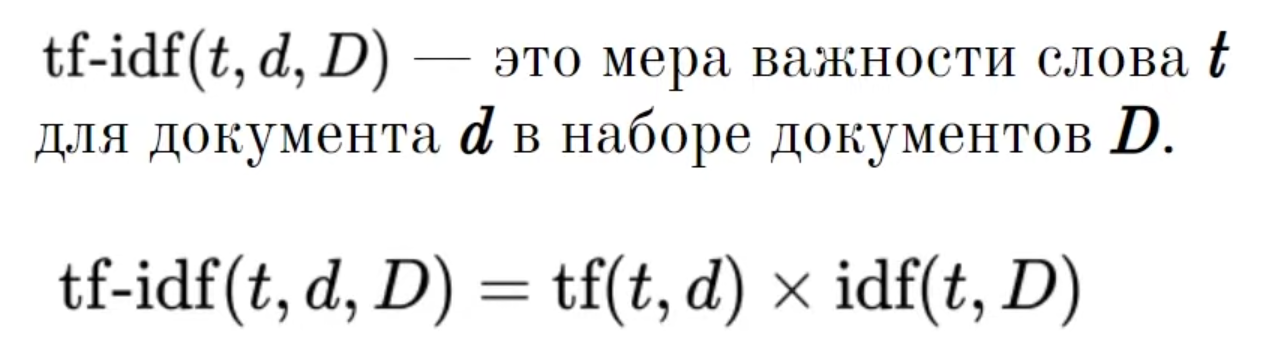
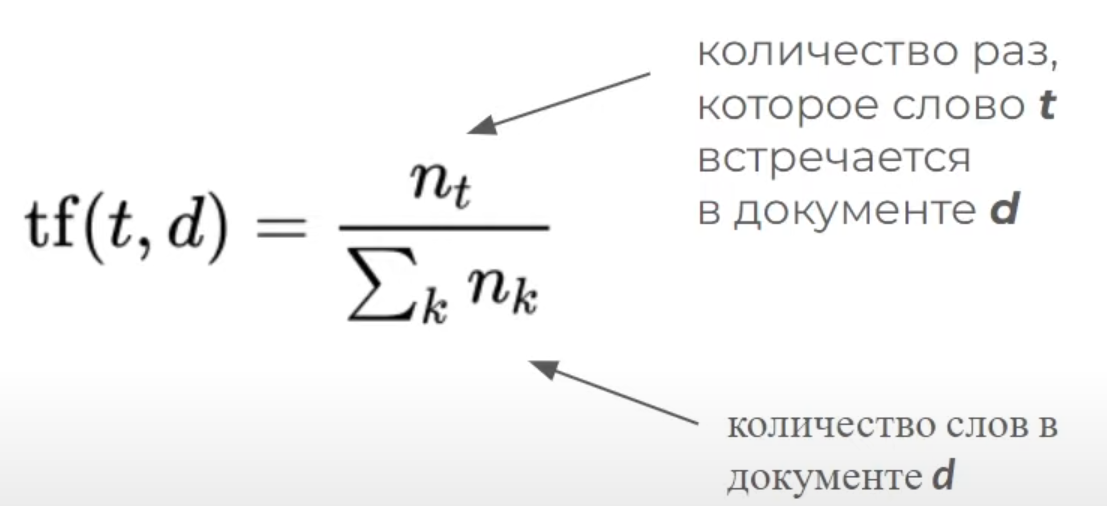
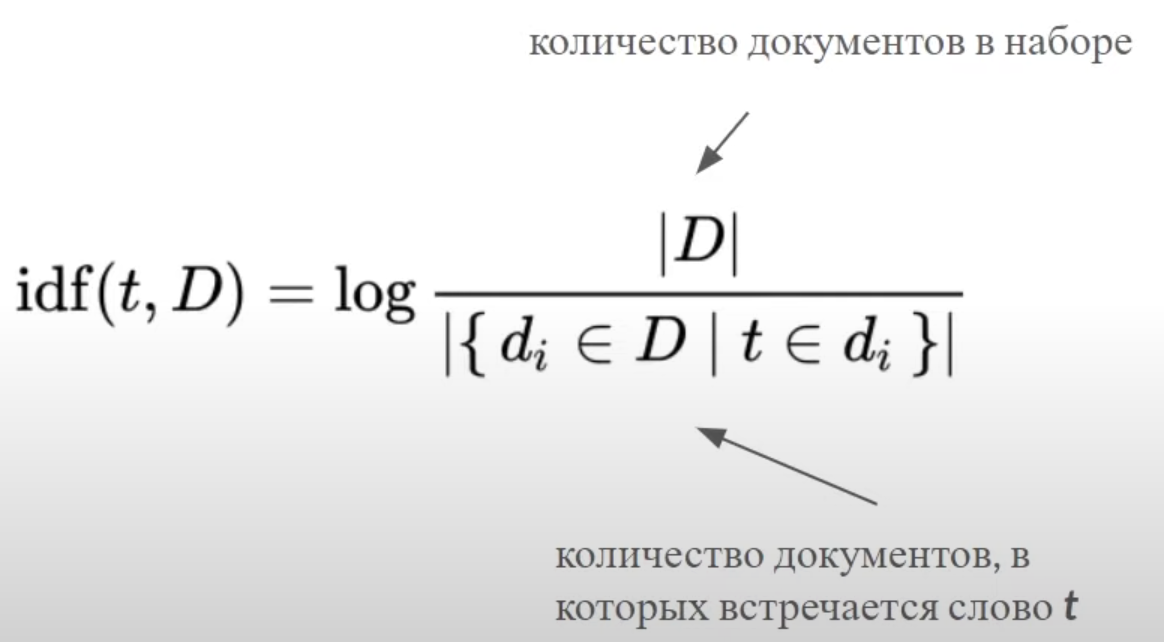

In [1]:
import math

In [ ]:
def TF_IDF(word: str, article_id: int, *args):
    word = word.lower()
    article_list = [] 
    articles_with_word_count = 0
    for article in args:
        with open(article) as file:
            article_lines = file.read()
            article_lines = article_lines.replace("'", "").replace("\n", "").replace(".", "").replace(",", "")\
                .replace("-", "").replace(";", "")
            article_lines = article_lines.lower().split(" ")
            article_list.append(article_lines)
            if word in article_lines:
                articles_with_word_count += 1

    article = article_list[article_id]
    TF = article.count(word)/len(article)
    
    # print(article)
    # new_func(article_list)

    try:
        IDF = math.log(len(article_list)/articles_with_word_count, 10)
    except:
        IDF = None

    if TF == 0 or IDF == None:
        print("Word doesn't exist in any article. TF-IDF is none")
        return 0
    else:
        return TF*IDF

def new_func(article_list):
    print(article_list)
    
print(TF_IDF("мартин", 0, "test1.txt", "test2.txt", "test3.txt"))
print(TF_IDF("мартин", 0, "test1.txt", "test3.txt")) # важность слова больше, если IDF больше
print(TF_IDF("мартин", 2, "test1.txt", "test2.txt", "test3.txt"))
print(TF_IDF("рулетенбурге", 2, "test1.txt", "test2.txt", "test3.txt"))

# 0.0008906993376615137


0.0006309253280389869
0.0010785739722822686
Word doesn't exist in any article. TF-IDF is none
0
0.0011095843133015406


• Низкие значения: Обычно TF-IDF близкие к нулю указывают на то, что термин встречается редко в документе или в большинстве документов. Это может быть нормальным для общих слов или стоп-слов.

• Средние значения: Значения TF-IDF в диапазоне от 0.1 до 1 могут указывать на умеренно важные термины, которые имеют некоторую значимость для конкретного документа.

• Высокие значения: TF-IDF больше 1 или даже значительно больше 1 говорит о том, что термин встречается часто в данном документе и редко в других документах. Это указывает на высокую значимость термина для данного документа.


# Word2vec

In [3]:
import math
import re
import torch
import torch.nn as nn
import torch.utils.data.dataloader as DataLoader
import torch.utils.data.dataset as Dataset

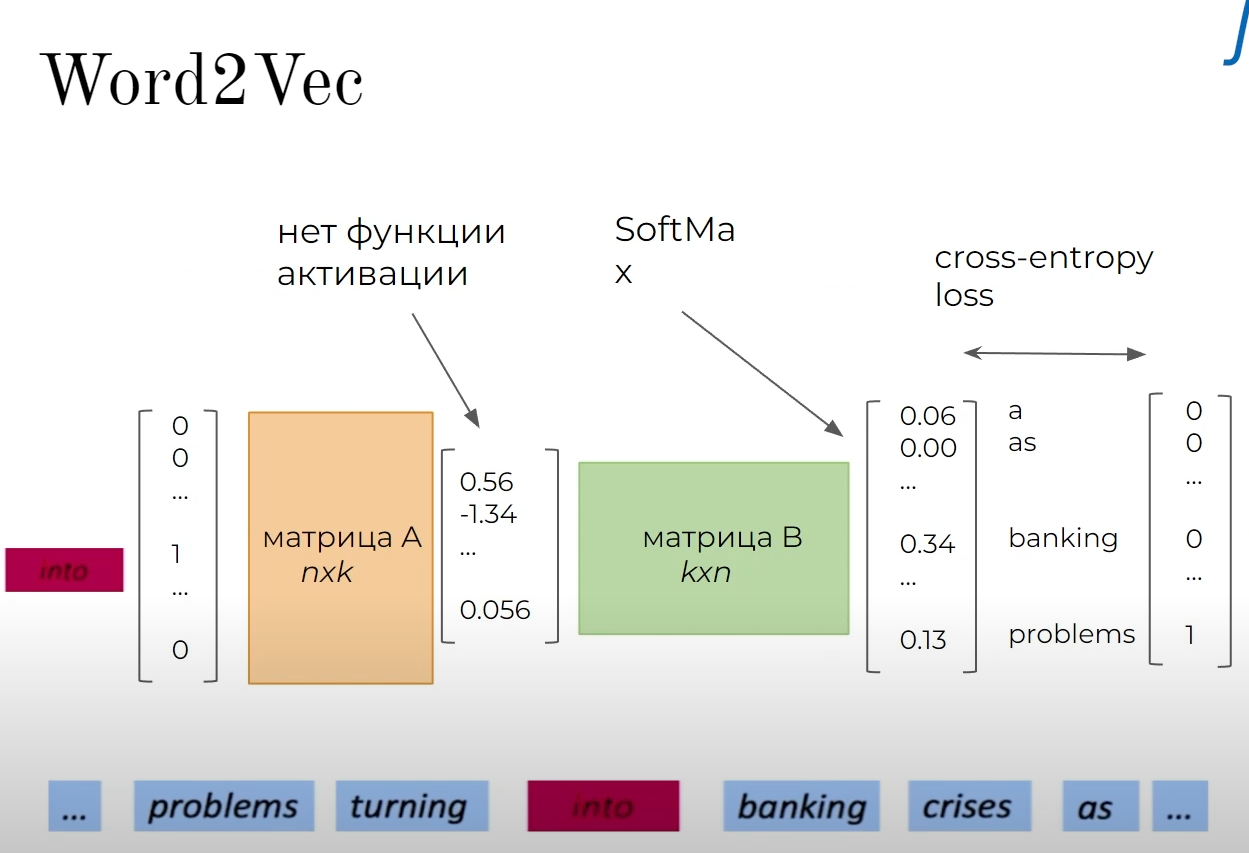

In [4]:
import re
import numpy as np
import torch
import math
from numpy import dot
from numpy.linalg import norm


def prepare_text(text: str):
    # Удаляем все символы кроме a-z, @, и #
	text = re.sub(r'[^a-z@# ]', '', text.lower())   
	# Разбиваем по словам
	tokens = text.split()    
	# Формируем словарь уникальных слов
	vocab = set(tokens)
	# Формируем слова слов с указанием индекса  слова в словаре
	word_to_ix = {word: i for i, word in enumerate(vocab)}
	return word_to_ix

def get_one_hot_vector(word: str, vocab: dict):
    if word in vocab:
        vector = torch.zeros(len(vocab))
        vector[vocab[word]] = 1
        return vector
    return None

def logits_to_one_hot(logits):
    max_p = 0
    one_i = -1
    # print("LOGITS TO ONE HOT")
    for i, x in enumerate(logits):
        # print(i, x.item())
        if x.item() > max_p:    
            max_p = x.item()
            one_i = i
    # print("MAX P", max_p)
    # print("ONE I", one_i)
    
    tensor = torch.zeros(len(logits))
    tensor[one_i] = 1
    return tensor
    # print("TENSOR", tensor)

def softmax(logits: list):
    res = []
    n = len(logits)
    for i in range(n):
        summ = 0
        for j in range(n):
            summ += math.exp(logits[j])
        res.append(math.exp(logits[i])/summ)
    return torch.tensor(res) 


class Word2VecModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Word2VecModel, self).__init__()
        self.matrix_a = nn.Linear(input_size, hidden_size)
        self.matrix_b = nn.Linear(hidden_size, input_size)
        # [1xk] * [kxn] = [1xn]

    def forward(self, x):
        x = self.matrix_a(x)
        x = self.matrix_b(x)
        m = nn.Softmax(dim=0)
        x = m(x)
        return x
        # return logits_to_one_hot(x)

def vector_to_word(vector, vocab):
    for i in range(len(vector)):
        # print(vector[i].item())
        if vector[i].item() == 1:
            # print(list(vocab.keys())[list(vocab.values()).index(i)])
            return list(vocab.keys())[list(vocab.values()).index(i)]


# text = "problems turning into banking crises as"
text = "In a kingdom, the king ruled with wisdom and strength. He was a powerful leader, admired by his subjects. The queen, his beloved partner, stood by his side, sharing the responsibilities of governance. Together, they represented the harmony between male and female leadership. The king often consulted the queen on matters of state, recognizing her intelligence and insight. In this royal family, the bond between the king and queen symbolized the balance of power and love."
text1 = re.sub(r'[^a-z@# ]', '', text.lower())
text1 = text1.split()
vocab = prepare_text(text)
# print("VOCAB", vocab)


window = 1
input_size = len(vocab)
hidden_size = 5

# X = get_one_hot_vector("sun", vocab) # word one hot vector 
# Y = get_one_hot_vector("rises", vocab) # target data for training
# print("Y", Y)

w2v = Word2VecModel(input_size, hidden_size)
# logits = w2v(X)

# print("X", X)
# print("logits bf training", logits)

learning_rate = 0.01
n_iters = 100

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(w2v.parameters(), lr=learning_rate)

# print(text1)

for i in range(len(text1)):
    word = text1[i]
    for j in range(i-window, i+window+1):
        if j > 0 and j < len(text1) and i!= j:
            context_word = text1[j]
            X = get_one_hot_vector(word, vocab) # word one hot vector 
            Y = get_one_hot_vector(context_word, vocab) # target data for training

            # print(X, Y)
            # print(vector_to_word(X, vocab), vector_to_word(Y, vocab))

            logits = w2v(X)

            # print("X", X)
            # print("logits bf training", logits)

            for epoch in range(n_iters):
                y_predicted = w2v(X)
                l = loss(y_predicted, Y)
                # print(y_predicted, Y)
                l.backward()
                optimizer.step()
                optimizer.zero_grad()

                if epoch % 10 == 0:
                    # print("Y_PRED", y_predicted)
                    # [w, b] = w2v.parameters()
                    params = list(w2v.parameters())  # преобразуем параметры в список
                    w = params[0]  # веса для первого слоя (matrix_a)
                    b = params[1]  # веса для второго слоя (matrix_b)
                    # print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l.item())

            logits = w2v(X)
            # print("logits af training", logits)
            # print("RES", vector_to_word(logits_to_one_hot(logits), vocab))


In [5]:
print(vocab)
king = w2v(get_one_hot_vector("king", vocab))
queen = w2v(get_one_hot_vector("queen", vocab))
man = w2v(get_one_hot_vector("male", vocab))
woman = w2v(get_one_hot_vector("female", vocab))
power = w2v(get_one_hot_vector("power", vocab))

# print(king)
# print(queen)
# print(man)
# print(woman)

cos = nn.CosineSimilarity(dim=0, eps=1e-6)
print(cos(king, woman))
print(cos(king, man))
print(cos(queen, woman))
print(cos(queen, man))
print(cos(power, man))
print(cos(power, woman))

# queen = king - man + woman
new_queen = king - man + woman
print(new_queen)
print(queen)
print(cos(queen, new_queen))
print(cos(queen, queen))

{'on': 0, 'matters': 1, 'subjects': 2, 'family': 3, 'powerful': 4, 'often': 5, 'intelligence': 6, 'her': 7, 'was': 8, 'in': 9, 'insight': 10, 'bond': 11, 'sharing': 12, 'male': 13, 'he': 14, 'represented': 15, 'of': 16, 'royal': 17, 'stood': 18, 'with': 19, 'this': 20, 'recognizing': 21, 'strength': 22, 'kingdom': 23, 'responsibilities': 24, 'ruled': 25, 'leader': 26, 'his': 27, 'female': 28, 'between': 29, 'they': 30, 'the': 31, 'leadership': 32, 'beloved': 33, 'harmony': 34, 'side': 35, 'governance': 36, 'king': 37, 'consulted': 38, 'a': 39, 'wisdom': 40, 'queen': 41, 'partner': 42, 'symbolized': 43, 'by': 44, 'together': 45, 'balance': 46, 'state': 47, 'love': 48, 'and': 49, 'admired': 50, 'power': 51}
tensor(0.9972, grad_fn=<SumBackward1>)
tensor(0.9979, grad_fn=<SumBackward1>)
tensor(0.9979, grad_fn=<SumBackward1>)
tensor(0.9981, grad_fn=<SumBackward1>)
tensor(0.9986, grad_fn=<SumBackward1>)
tensor(0.9969, grad_fn=<SumBackward1>)
tensor([0.0215, 0.0238, 0.0138, 0.0299, 0.0189, 0.0

In [6]:
import torch
import torch.nn as nn


X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

n_samples, n_features = X.shape
print(f'#samples: {n_samples}, #features: {n_features}')

X_test = torch.tensor([5], dtype=torch.float32)
print("X_test", X_test)

input_size = n_features
output_size = n_features

class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)

model = LinearRegression(input_size, output_size) # 1x1
print(f'Prediction before training X test: f(5) = {model(X_test)}')

learning_rate = 0.01
n_iters = 100

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(n_iters):
    y_predicted = model(X)
    [w, b] = model.parameters() # unpack parameters
    print("PARAMS_W", w)
    print("PARAMS_B", b)
    # print("y_predicted", y_predicted)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:
        print("pred", y_predicted)
        [w, b] = model.parameters() # unpack parameters
        print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l)

print(f'Prediction after training: f(5) = {model(X_test).item():.3f}')

#samples: 4, #features: 1
X_test tensor([5.])
Prediction before training X test: f(5) = tensor([3.8953], grad_fn=<ViewBackward0>)
PARAMS_W Parameter containing:
tensor([[0.9293]], requires_grad=True)
PARAMS_B Parameter containing:
tensor([-0.7511], requires_grad=True)
pred tensor([[0.1782],
        [1.1075],
        [2.0367],
        [2.9660]], grad_fn=<AddmmBackward0>)
epoch  1 : w =  1.127427101135254  loss =  tensor(13.1836, grad_fn=<MseLossBackward0>)
PARAMS_W Parameter containing:
tensor([[1.1274]], requires_grad=True)
PARAMS_B Parameter containing:
tensor([-0.6825], requires_grad=True)
PARAMS_W Parameter containing:
tensor([[1.2924]], requires_grad=True)
PARAMS_B Parameter containing:
tensor([-0.6252], requires_grad=True)
PARAMS_W Parameter containing:
tensor([[1.4298]], requires_grad=True)
PARAMS_B Parameter containing:
tensor([-0.5773], requires_grad=True)
PARAMS_W Parameter containing:
tensor([[1.5442]], requires_grad=True)
PARAMS_B Parameter containing:
tensor([-0.5373], requ